<a href="https://colab.research.google.com/github/Gajenders07/NBA-SHOT-PREDICTION/blob/main/NBA_Shot_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nba = pd.read_csv("/content/drive/MyDrive/Projects/shot_logs.csv")
df = nba.copy()
df.head()


In [ ]:
df.shape


(128069, 21)

In [ ]:
df.isnull().sum()


GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
player_name                      0
player_id                        0
dtype: int64

In [ ]:
df[df.SHOT_CLOCK.isnull()==True].head()


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
24,21400845,"FEB 25, 2015 - CHA @ CHI",A,W,12,6,2,0:04,NaN,0,...,25.2,3,missed,"Butler, Jimmy",202710,3.6,0,0,brian roberts,203148
54,21400768,"FEB 08, 2015 - CHA vs. IND",H,L,-1,14,4,0:01,NaN,5,...,34.4,3,missed,"Hill, George",201588,3.6,0,0,brian roberts,203148
76,21400742,"FEB 05, 2015 - CHA vs. WAS",H,W,7,10,3,0:01,NaN,2,...,13.1,2,made,"Butler, Rasual",2446,2.5,1,2,brian roberts,203148
129,21400611,"JAN 19, 2015 - CHA vs. MIN",H,W,25,7,2,0:02,NaN,5,...,12.0,2,missed,"Williams, Mo",2590,4.0,0,0,brian roberts,203148


In [ ]:
df.SHOT_CLOCK = df.SHOT_CLOCK.fillna(df.SHOT_CLOCK.mean())

In [ ]:
df.isnull().sum()

GAME_ID                       0
MATCHUP                       0
LOCATION                      0
W                             0
FINAL_MARGIN                  0
SHOT_NUMBER                   0
PERIOD                        0
GAME_CLOCK                    0
SHOT_CLOCK                    0
DRIBBLES                      0
TOUCH_TIME                    0
SHOT_DIST                     0
PTS_TYPE                      0
SHOT_RESULT                   0
CLOSEST_DEFENDER              0
CLOSEST_DEFENDER_PLAYER_ID    0
CLOSE_DEF_DIST                0
FGM                           0
PTS                           0
player_name                   0
player_id                     0
dtype: int64

In [ ]:
df.describe()

In [ ]:
len(df.TOUCH_TIME[df.TOUCH_TIME<0])


312

In [ ]:
df.TOUCH_TIME[df.TOUCH_TIME<0] = df.TOUCH_TIME.mean()

In [ ]:
len(df.TOUCH_TIME[df.TOUCH_TIME>24.0])


4

In [ ]:
df.TOUCH_TIME[df.TOUCH_TIME>24.0] = 24

<ipython-input-13-311d7ed9d614>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.TOUCH_TIME[df.TOUCH_TIME>24.0] = 24


In [ ]:
df.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.778681,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.636611,3.477760,2.983448,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.400000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.453344,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.400000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.000000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  128069 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

In [ ]:
df.LOCATION = df.LOCATION.map({"H":1,"A":0})
df.W = df.W.map({"W":1,"L":0})
df.PTS_TYPE = df.PTS_TYPE.map({2:0,3:1})
df.SHOT_RESULT = df.SHOT_RESULT.map({"made":1,"missed":0})

In [ ]:
df = df.rename(columns={"LOCATION":"HOME_AWAY","PTS_TYPE":"3PTS_SHOT","player_name":"PLAYER_NAME","player_id":"PLAYER_ID"})


In [ ]:
df.nunique()

In [ ]:
df.head()

In [ ]:
df.GAME_CLOCK = df.GAME_CLOCK.apply(lambda x: int(x.split(":")[0])*60 + int(x.split(":")[1]))

In [ ]:
df.head()

In [ ]:
df = df.drop(columns=["GAME_ID",
                          "MATCHUP",
                          "W",
                          "PLAYER_NAME",
                          "SHOT_NUMBER",
                          "CLOSEST_DEFENDER",
                          "CLOSEST_DEFENDER_PLAYER_ID",
                          "FGM",
                          "PTS",
                          "PLAYER_ID"], axis=1)

In [ ]:
df.head()

In [ ]:
X1 = df[["HOME_AWAY",	"FINAL_MARGIN",	"PERIOD",	"GAME_CLOCK",	"SHOT_CLOCK",	"DRIBBLES",	"TOUCH_TIME",	"SHOT_DIST", "3PTS_SHOT",	"CLOSE_DEF_DIST"]]
Y1 = df['SHOT_RESULT']


In [ ]:
X1_Train, X1_Test, Y1_Train, Y1_Test = train_test_split(X1, Y1, test_size=0.2)

In [ ]:
%%time
xgbst1 = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, objective='binary:logistic')

xgbst1.fit(X1_Train, Y1_Train)

Y1_Pred = xgbst1.predict(X1_Test)

CPU times: user 799 ms, sys: 6.64 ms, total: 805 ms
Wall time: 429 ms


In [ ]:
Accuracy = accuracy_score(Y1_Test, Y1_Pred)
Confusion_Matrix = confusion_matrix(Y1_Test, Y1_Pred)
Classification_Report = classification_report(Y1_Test, Y1_Pred)

print(f'Accuracy: {Accuracy}')
print('Confusion Matrix:')
print(Confusion_Matrix)
print('Classification Report:')
print(Classification_Report)

Accuracy: 0.6220035917857422
Confusion Matrix:
[[12195  1896]
 [ 7786  3737]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.87      0.72     14091
           1       0.66      0.32      0.44     11523

    accuracy                           0.62     25614
   macro avg       0.64      0.59      0.58     25614
weighted avg       0.63      0.62      0.59     25614



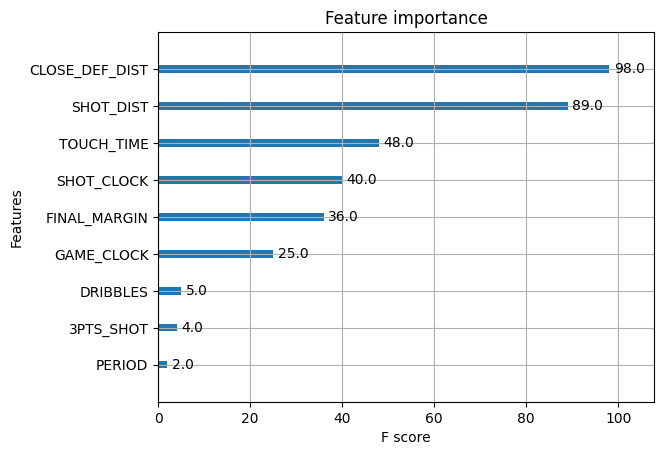

In [ ]:
# plot feature importance
plot_importance(xgbst1)
plt.show()

In [ ]:
X2 = df[["FINAL_MARGIN",	"SHOT_CLOCK",	"TOUCH_TIME",	"SHOT_DIST",	"CLOSE_DEF_DIST"]]
Y2 = df['SHOT_RESULT']

In [ ]:
X2_Train, X2_Test, Y2_Train, Y2_Test = train_test_split(X2, Y2, test_size=0.2)

In [ ]:
%%time
xgbst2 = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, objective='binary:logistic')

xgbst2.fit(X2_Train, Y2_Train)

Y2_Pred = xgbst2.predict(X2_Test)

CPU times: user 645 ms, sys: 6.55 ms, total: 652 ms
Wall time: 349 ms


In [ ]:
Accuracy = accuracy_score(Y2_Test, Y2_Pred)
Confusion_Matrix = confusion_matrix(Y2_Test, Y2_Pred)
Classification_Report = classification_report(Y2_Test, Y2_Pred)

print(f'Accuracy: {Accuracy}')
print('Confusion Matrix:')
print(Confusion_Matrix)
print('Classification Report:')
print(Classification_Report)

Accuracy: 0.623955649254314
Confusion Matrix:
[[12094  2100]
 [ 7532  3888]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.85      0.72     14194
           1       0.65      0.34      0.45     11420

    accuracy                           0.62     25614
   macro avg       0.63      0.60      0.58     25614
weighted avg       0.63      0.62      0.60     25614



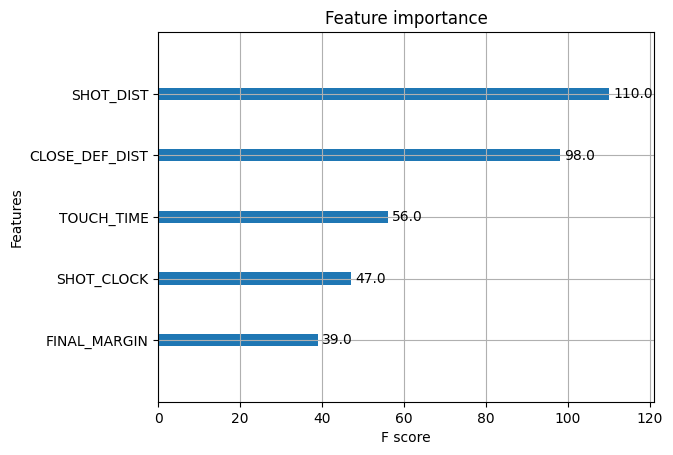

In [ ]:
plot_importance(xgbst2)
plt.show()

In [ ]:
scaler = StandardScaler()
X_Train_scaled = scaler.fit_transform(X2_Train)
X_Test_scaled = scaler.transform(X2_Test)

In [ ]:
%%time
SVM_Model = SVC(kernel='linear')
SVM_Model.fit(X_Train_scaled, Y2_Train)

CPU times: user 9min 9s, sys: 1.12 s, total: 9min 11s
Wall time: 9min 33s


SVC(kernel='linear')

In [ ]:
Y3_Pred = SVM_Model.predict(X_Test_scaled)

In [ ]:
Accuracy = accuracy_score(Y2_Test, Y3_Pred)
Confusion_Matrix = confusion_matrix(Y2_Test, Y3_Pred)
Classification_Report = classification_report(Y2_Test, Y3_Pred)

print(f'Accuracy: {Accuracy}')
print('Confusion Matrix:')
print(Confusion_Matrix)
print('Classification Report:')
print(Classification_Report)

Accuracy: 0.5985398610135082
Confusion Matrix:
[[9499 4695]
 [5588 5832]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     14194
           1       0.55      0.51      0.53     11420

    accuracy                           0.60     25614
   macro avg       0.59      0.59      0.59     25614
weighted avg       0.60      0.60      0.60     25614



In [ ]:
%%time
RF_Model = RandomForestClassifier(n_estimators=50, max_depth=3)
RF_Model.fit(X2_Train, Y2_Train)
Y4_Pred = RF_Model.predict(X2_Test)


CPU times: user 1.97 s, sys: 6 ms, total: 1.97 s
Wall time: 1.98 s


In [ ]:
Accuracy = accuracy_score(Y2_Test, Y4_Pred)
Confusion_Matrix = confusion_matrix(Y2_Test, Y4_Pred)
Classification_Report = classification_report(Y2_Test, Y4_Pred)

print(f'Accuracy: {Accuracy}')
print('Confusion Matrix:')
print(Confusion_Matrix)
print('Classification Report:')
print(Classification_Report)

Accuracy: 0.6133754977746545
Confusion Matrix:
[[11510  2684]
 [ 7219  4201]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.81      0.70     14194
           1       0.61      0.37      0.46     11420

    accuracy                           0.61     25614
   macro avg       0.61      0.59      0.58     25614
weighted avg       0.61      0.61      0.59     25614



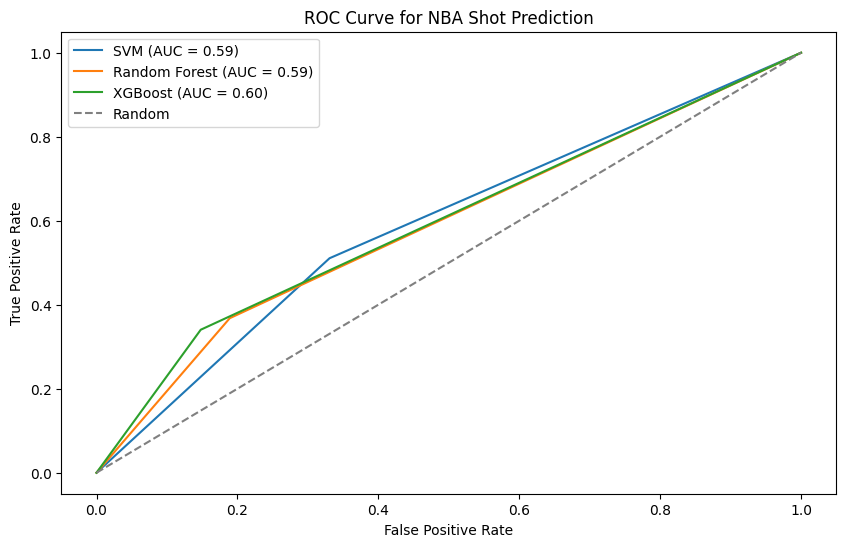

In [ ]:
# SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(Y2_Test, Y3_Pred,pos_label=1)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y2_Test,Y4_Pred,pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(Y2_Test,Y2_Pred,pos_label=1)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.2f})'.format(roc_auc_svm))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(roc_auc_xgb))

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NBA Shot Prediction')
plt.legend()
plt.show()